In [1]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Fri Sep 30 00:16:39 2022
Driver Version                            : 510.54
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:64:00.0
    Product Name                          : NVIDIA GeForce RTX 2080 Ti
    Product Brand                         : GeForce
    Product Architecture                  : Turing
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Enabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : N/A
    GPU UUID       

In [2]:
!pwd

/ssl-jet-vol/semi-supervised-tests/Jupyter


In [3]:
import math
import logging
import copy
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.loader import DataListLoader
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import index_to_mask

import sys
sys.path.insert(0, '..')  #go up one directory
from src.data.jetnet_graph import JetNetGraph
from src.models.unimp_model import UniMP
from src.models.mask_feature import MaskFeature
from custom_libraries.my_functions import *
from focal_loss import FocalLoss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

logging.basicConfig(level=logging.INFO)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
def train(model, loader, optimizer, label_rate=0.85, loss_fcn=F.cross_entropy):
    model.train()

    sum_loss = 0
    sum_true = 0
    sum_all = 0
    for i, data in enumerate(loader):
        optimizer.zero_grad()

        train_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
        propagation_mask = MaskFeature.ratio_mask(train_mask, ratio=label_rate)
        supervision_mask = train_mask ^ propagation_mask

        data = data.cuda()
        out = model(data.x, data.y, data.edge_index, propagation_mask)
        loss = loss_fcn(out[supervision_mask], data.y[supervision_mask])
        loss.backward()
        sum_loss += float(loss)
        optimizer.step()

        pred = out[supervision_mask].argmax(dim=-1)
        sum_true += int((pred == data.y[supervision_mask]).sum())
        sum_all += pred.size(0)
        logging.info(f"Batch: {i + 1:03d}, Train Loss: {sum_loss:.4f}")

    return float(sum_loss) / (i + 1), float(sum_true) / sum_all

In [5]:
@torch.no_grad()
def test(model, loader, label_rate=0.85, output_pred=False):
    model.eval()

    sum_true = 0
    sum_all = 0
    out_lst, pred_lst, supervision_mask_lst, test_mask_lst = [], [], [], []
    for data in loader:
        data = data.cuda()
        test_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
        propagation_mask = MaskFeature.ratio_mask(test_mask, ratio=label_rate, fix_seed=True)
        supervision_mask = test_mask ^ propagation_mask

        out = model(data.x, data.y, data.edge_index, propagation_mask)
        pred = out[supervision_mask].argmax(dim=-1)
        sum_true += int((pred == data.y[supervision_mask]).sum())
        sum_all += pred.size(0)
        
        out_lst.append(out)
        pred_lst.append(pred)
        test_mask_lst.append(test_mask)
        supervision_mask_lst.append(supervision_mask)
    if output_pred:
        return out_lst, pred_lst, float(sum_true) / sum_all, test_mask_lst, supervision_mask_lst
    else:
        return float(sum_true) / sum_all


def collate_fn(items):
    sum_list = sum(items, [])
    return Batch.from_data_list(sum_list)

In [6]:
def reset_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(layer)
            layer.reset_parameters()
        else:
            for sublayer in layer:
                if hasattr(sublayer, 'reset_parameters'):
                    print(sublayer)
                    sublayer.reset_parameters()

In [7]:
# train_root = osp.join(osp.dirname(osp.realpath(__file__)), "..", "..", "data", "train")
# val_root = osp.join(osp.dirname(osp.realpath(__file__)), "..", "..", "data", "val")
train_root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/train"
val_root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/val"
max_jets = 1000
train_dataset = JetNetGraph(train_root, max_jets=max_jets, file_start=0, file_stop=1)
val_dataset = JetNetGraph(val_root, max_jets=max_jets, file_start=1, file_stop=2)
batch_size = 1  #1k jets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate_fn
val_loader = DataListLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
val_loader.collate_fn = collate_fn

model = UniMP(
    in_channels=train_dataset.num_features,
    num_classes=train_dataset.num_classes,
    hidden_channels=64,
    num_layers=3,
    heads=2,
).to(device)

logging.info("Model summary")
logging.info(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

cuda


INFO:root:Model summary
INFO:root:UniMP(
  (label_emb): MaskLabel()
  (convs): ModuleList(
    (0): TransformerConv(3, 32, heads=2)
    (1): TransformerConv(64, 32, heads=2)
    (2): TransformerConv(64, 5, heads=2)
  )
  (norms): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)


In [8]:
reset_params(model)
num_epochs = 100
train_loss_lst, val_acc_lst, train_acc_lst = [], [], []
best_val_acc = 0
best_epoch = 0
# Set up Focal loss
gamma = 1
floss = FocalLoss(gamma=gamma, reduction='mean')

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fcn=floss)
    val_acc = test(model, val_loader)
    logging.info(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    is_best_epoch = (val_acc > best_val_acc)
    if is_best_epoch:
        # Save the model
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_state = copy.deepcopy(model.state_dict())
        save_dir = "/ssl-jet-vol/semi-supervised-tests/Jupyter/trained_models/" + "_best_epoch_full.pt"
        torch.save(best_model_state, save_dir)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_acc_lst.append(val_acc)
    logging.info(
                "Epoch #%d: Current validation metric: %.5f (best: %.5f)"
                % (epoch, val_acc, best_val_acc)
            )
    np.savetxt("/ssl-jet-vol/semi-supervised-tests/Jupyter/trained_models/" + "_training_losses.txt", train_loss_lst)

MaskLabel()
TransformerConv(3, 32, heads=2)
TransformerConv(64, 32, heads=2)
TransformerConv(64, 5, heads=2)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)


INFO:root:Batch: 001, Train Loss: 1.1880
INFO:root:Epoch: 001, Train Loss: 1.1880, Train Acc: 0.4269, Val Acc: 0.4902
INFO:root:Epoch #1: Current validation metric: 0.49024 (best: 0.49024)
INFO:root:Batch: 001, Train Loss: 1.0829
INFO:root:Epoch: 002, Train Loss: 1.0829, Train Acc: 0.4729, Val Acc: 0.4958
INFO:root:Epoch #2: Current validation metric: 0.49582 (best: 0.49582)
INFO:root:Batch: 001, Train Loss: 0.9927
INFO:root:Epoch: 003, Train Loss: 0.9927, Train Acc: 0.4781, Val Acc: 0.5009
INFO:root:Epoch #3: Current validation metric: 0.50093 (best: 0.50093)
INFO:root:Batch: 001, Train Loss: 0.9188
INFO:root:Epoch: 004, Train Loss: 0.9188, Train Acc: 0.4799, Val Acc: 0.5076
INFO:root:Epoch #4: Current validation metric: 0.50759 (best: 0.50759)
INFO:root:Batch: 001, Train Loss: 0.8602
INFO:root:Epoch: 005, Train Loss: 0.8602, Train Acc: 0.4853, Val Acc: 0.5169
INFO:root:Epoch #5: Current validation metric: 0.51689 (best: 0.51689)
INFO:root:Batch: 001, Train Loss: 0.8126
INFO:root:Epoc

INFO:root:Epoch: 044, Train Loss: 0.4866, Train Acc: 0.5685, Val Acc: 0.5866
INFO:root:Epoch #44: Current validation metric: 0.58661 (best: 0.58661)
INFO:root:Batch: 001, Train Loss: 0.4846
INFO:root:Epoch: 045, Train Loss: 0.4846, Train Acc: 0.5693, Val Acc: 0.5875
INFO:root:Epoch #45: Current validation metric: 0.58754 (best: 0.58754)
INFO:root:Batch: 001, Train Loss: 0.4827
INFO:root:Epoch: 046, Train Loss: 0.4827, Train Acc: 0.5707, Val Acc: 0.5879
INFO:root:Epoch #46: Current validation metric: 0.58785 (best: 0.58785)
INFO:root:Batch: 001, Train Loss: 0.4808
INFO:root:Epoch: 047, Train Loss: 0.4808, Train Acc: 0.5709, Val Acc: 0.5896
INFO:root:Epoch #47: Current validation metric: 0.58956 (best: 0.58956)
INFO:root:Batch: 001, Train Loss: 0.4789
INFO:root:Epoch: 048, Train Loss: 0.4789, Train Acc: 0.5717, Val Acc: 0.5891
INFO:root:Epoch #48: Current validation metric: 0.58909 (best: 0.58956)
INFO:root:Batch: 001, Train Loss: 0.4771
INFO:root:Epoch: 049, Train Loss: 0.4771, Train Ac

INFO:root:Epoch #87: Current validation metric: 0.58646 (best: 0.58987)
INFO:root:Batch: 001, Train Loss: 0.4475
INFO:root:Epoch: 088, Train Loss: 0.4475, Train Acc: 0.5770, Val Acc: 0.5863
INFO:root:Epoch #88: Current validation metric: 0.58630 (best: 0.58987)
INFO:root:Batch: 001, Train Loss: 0.4472
INFO:root:Epoch: 089, Train Loss: 0.4472, Train Acc: 0.5772, Val Acc: 0.5865
INFO:root:Epoch #89: Current validation metric: 0.58646 (best: 0.58987)
INFO:root:Batch: 001, Train Loss: 0.4468
INFO:root:Epoch: 090, Train Loss: 0.4468, Train Acc: 0.5779, Val Acc: 0.5861
INFO:root:Epoch #90: Current validation metric: 0.58615 (best: 0.58987)
INFO:root:Batch: 001, Train Loss: 0.4465
INFO:root:Epoch: 091, Train Loss: 0.4465, Train Acc: 0.5781, Val Acc: 0.5865
INFO:root:Epoch #91: Current validation metric: 0.58646 (best: 0.58987)
INFO:root:Batch: 001, Train Loss: 0.4462
INFO:root:Epoch: 092, Train Loss: 0.4462, Train Acc: 0.5781, Val Acc: 0.5865
INFO:root:Epoch #92: Current validation metric: 0.

### Question: why is this constant for any max_jets
Need to delete the .pt files in the "processed" folder

## Load the saved model

In [9]:
model = UniMP(
    in_channels=train_dataset.num_features,
    num_classes=train_dataset.num_classes,
    hidden_channels=64,
    num_layers=3,
    heads=2,
).to(device)
save_dir = "/ssl-jet-vol/semi-supervised-tests/Jupyter/trained_models/" + "_best_epoch_full.pt"
model.load_state_dict(torch.load(save_dir))
model.eval()

UniMP(
  (label_emb): MaskLabel()
  (convs): ModuleList(
    (0): TransformerConv(3, 32, heads=2)
    (1): TransformerConv(64, 32, heads=2)
    (2): TransformerConv(64, 5, heads=2)
  )
  (norms): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)

In [12]:
# This shows that the two models are the same
for var_name in model.state_dict():
    print(model.state_dict()[var_name] == best_model_state[var_name])

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]], device='cuda:0')
tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
  

In [29]:
val_acc_lst = [1,2,3]
len(val_acc_lst)

3

In [10]:
val_acc_lst = []
for i in range(10):
    out_lst, pred_lst, val_acc, test_mask_lst, supervision_mask_lst = test(model, val_loader, output_pred=True)
    print(val_acc)
    val_acc_lst.append(val_acc)
print(f"average validation accuracy: {sum(val_acc_lst)/len(val_acc_lst)}")


0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
0.589866749302758
average validation accuracy: 0.5898667493027581


### Question: why do I get different outputs here, but none match best_val_acc

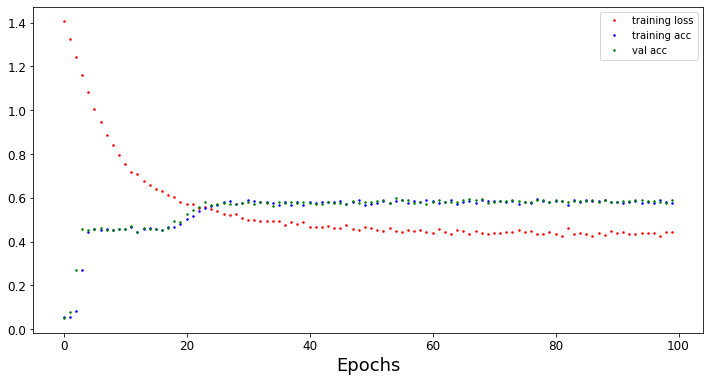

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
marker_size = 3
plt.plot(train_loss_lst, "r.", markersize=marker_size, label="training loss")
plt.plot(train_acc_lst, "b.", markersize=marker_size, label="training acc")
plt.plot(val_acc_lst, "g.",markersize=marker_size, label="val acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()
odir = "/ssl-jet-vol/semi-supervised-tests/Jupyter/plots"
fig.savefig("%s/loss_acc_curve.pdf" % (odir))
fig.savefig("%s/loss_acc_curve.png" % (odir))

### Obtain predicted probabilities

In [9]:
out_lst, pred_lst, test_acc, test_mask_lst, supervision_mask_lst = test(model, val_loader, output_pred=True)
m = torch.nn.Softmax(dim=1)
out_norm_lst = []  # the predicted probabilities
for out in out_lst:
    out_norm_lst.append(m(out))

In [10]:
out_norm_lst[1].size()

torch.Size([44416, 5])

In [11]:
out_norm = torch.cat(out_norm_lst)
print(out_norm.size())

torch.Size([130961, 5])


In [12]:
for supervision_mask in supervision_mask_lst:
    print(supervision_mask.shape)

torch.Size([42985])
torch.Size([44416])
torch.Size([43560])


In [13]:
for data in val_loader:
    print(data.y.shape)

torch.Size([42985])
torch.Size([44416])
torch.Size([43560])


In [14]:
for elem in pred_lst:
    print(elem.size()[0])

6543
6622
6597


In [15]:
pred = torch.cat(pred_lst)
print(pred.size()[0])

19762


In [16]:
0 in pred

False

In [17]:
1 in pred

False

In [18]:
2 in pred

True

In [19]:
3 in pred

True

In [20]:
4 in pred

False

The 5 cells above shows that the model ONLY predicted classes 2 (photon) and classes 3 (charged_hadron)

### Plot class balance
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]

0
1
2


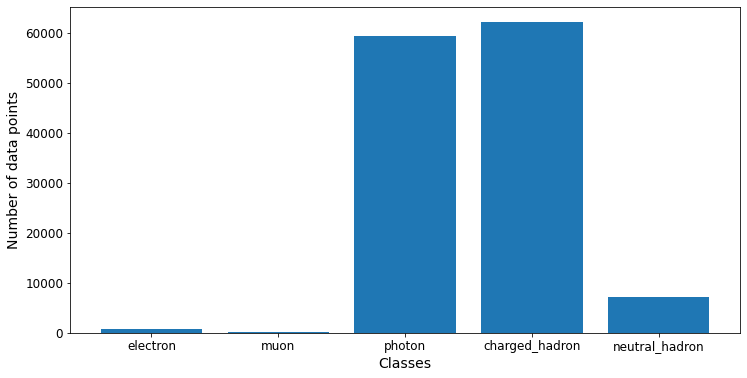

In [21]:
classes = np.array([i for i in range(5)])
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]
for i, data in enumerate(train_loader):
    data = data.cuda()
    train_mask = torch.ones_like(data.x[:, 0], dtype=torch.bool)
    print(i)
    if i == 0:
        labels_training = data.y[train_mask].cpu().numpy()
    else:
        labels_training = np.concatenate([labels_training, data.y[train_mask].cpu().numpy()]) 
    
class_dict = plot_class_balance(classes, labels_training, PDG_CLASSES, odir)

In [22]:
labels_training.shape

(129410,)

In [23]:
sum(list(class_dict.values()))

129410

### Plot accuracy for each class

0
labels: (6543,)
1
labels: (13165,)
2
labels: (19762,)
{0: [120, 0], 1: [5, 0], 2: [9091, 4859], 3: [9521, 6708], 4: [1025, 0]}


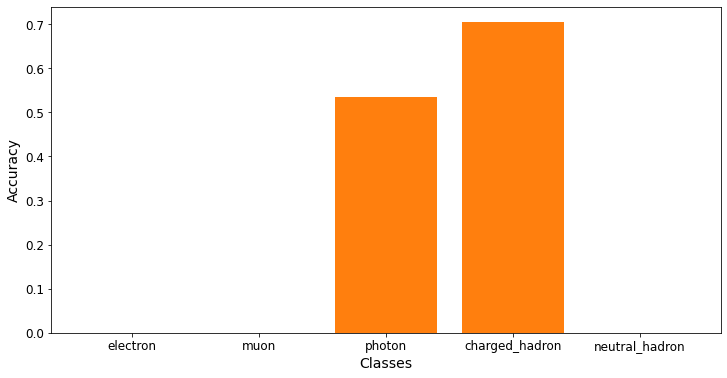

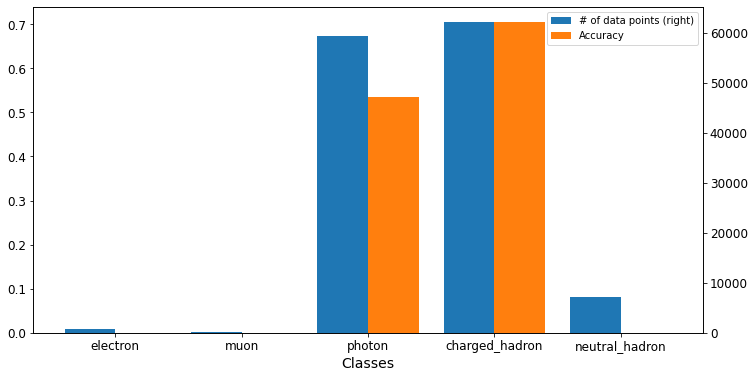

In [24]:
for i, data in enumerate(val_loader):
    data = data.cuda()
    supervision_mask = supervision_mask_lst[i]
    print(i)
    if i == 0:
        labels_val = data.y[supervision_mask].cpu().numpy()
    else:
        labels_val = np.concatenate([labels_val, data.y[supervision_mask].cpu().numpy()]) 
    print(f"labels: {labels_val.shape}")
plot_class_balance_and_accuracy(class_dict, labels_val, PDG_CLASSES, pred, odir)

0
1
2
0.65865958999423
0.2580452497848864
0.6716678541208215
0.6393960586110428
0.6806055320306631


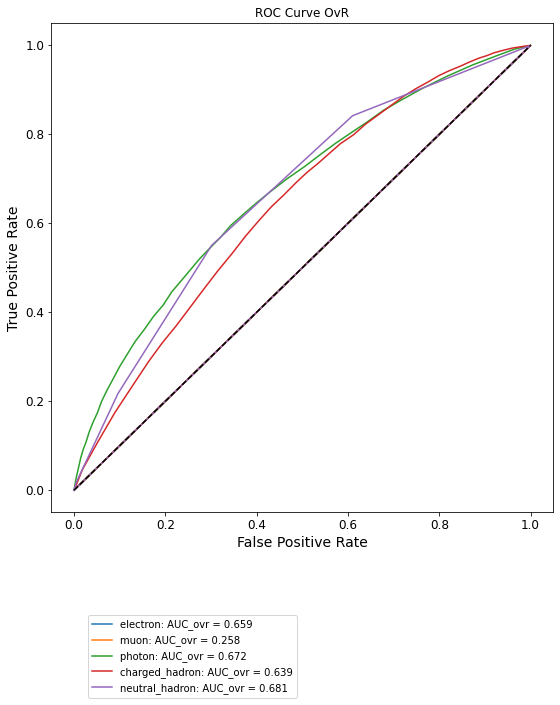

In [25]:
classes = np.array([i for i in range(5)])
for i, data in enumerate(val_loader):
    data = data.cuda()
#     test_mask = test_mask_lst[i]
    supervision_mask = supervision_mask_lst[i]
    print(i)
    if i == 0:
        labels_test = data.y[supervision_mask].cpu().numpy()
    else:
        labels_test = np.concatenate([labels_test, data.y[supervision_mask].cpu()]) 
roc_auc_ovr = plot_overlayed_roc_curve(classes, labels_test, out_norm[torch.cat(supervision_mask_lst)][:, classes], PDG_CLASSES, odir, label="all_classes", ncol=1)

In [36]:
def plot_overlayed_roc_curve(classes, labels, predictions, class_labels, odir, label = '', ax = None, figsize=(9, 9), ncol=2):
    """
    Plots overlayed ROC curves and returns a list of AUC.
    
    Args:
        classes: The classes used in classification. Must match with the predictions and labels.
                 i.e., if predictions consists of [..., 1, 3, 2, 1, 4, ...], then your classes cannot be ['photon', 'hadron', 'lepton']
        labels: The list of labels.
        predictions: The list of predicted classes. First dimension should match with the dimension of labels
        class_labels: List of actual names of the classes (instead of 0, 1, ...)
    Return:
        roc_auc_ovr: Dictionary of AUC, one for each class
    """
#     assert labels.size() == predictions[:, 0].size()
    if predictions.type() == 'torch.cuda.FloatTensor':
        predictions = predictions.cpu()
        
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    roc_auc_ovr = {}
    for i in range(len(classes)):
        c = classes[i]
        y_real = [1 if y == c else 0 for y in labels]
        y_proba = predictions[:, i]
        tpr, fpr = get_all_roc_coordinates(y_real, y_proba)
        
        # Calculates the ROC AUC
        roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach())
        print(roc_auc_ovr[c])
        
        ax.plot(fpr, tpr, label = f"{class_labels[i]}: AUC_ovr = {roc_auc_ovr[c]:.3f}")

    # plot the 50/50 lines
    x = np.linspace(0, 1, 10)
    Y = x
    plt.plot(x, Y, color='k', linestyle='dashed')
    # set limits and labels on axes
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right', shadow=False, ncol=ncol)
    plt.title("ROC Curve OvR")
    plt.show()
    fig.savefig("%s/roc_curve_%s.pdf" % (odir, label))
    fig.savefig("%s/roc_curve_%s.png" % (odir, label))
    
    return roc_auc_ovr

0.6716678541208215
0.6393960586110428


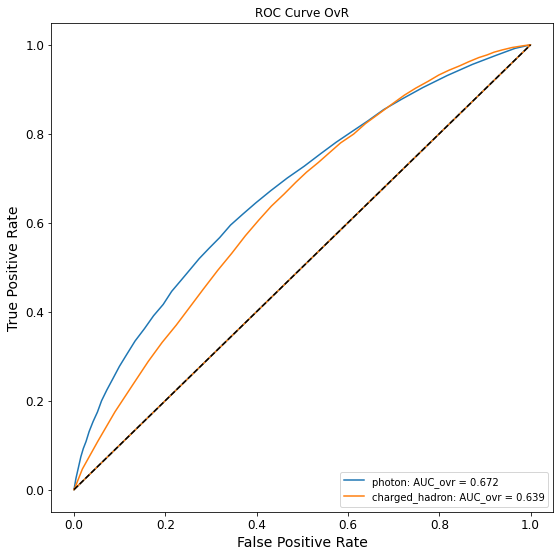

{2: 0.6716678541208215, 3: 0.6393960586110428}

In [37]:
classes = [2, 3]
class_labels = ["photon", "charged_hadron"]
plot_overlayed_roc_curve(classes, labels_test, out_norm[torch.cat(supervision_mask_lst)][:, classes], class_labels, odir, label="pch", ncol=1)

In [27]:
# import seaborn as sns
# from scipy import stats
# def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
#     '''
#     Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
#     Args:
#         tpr: The list of TPRs representing each coordinate.
#         fpr: The list of FPRs representing each coordinate.
#         scatter: When True, the points used on the calculation will be plotted with the line (default = True).
#     '''
#     if ax == None:
#         plt.figure(figsize = (5, 5))
#         ax = plt.axes()
    
#     if scatter:
#         sns.scatterplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-0.05, 1.05)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")

In [28]:
# # Plots the ROC Curves One vs Rest
# plt.figure(figsize = (12, 3))
# roc_auc_ovr = {}
# predictions = out_norm[test_mask]
# for i in range(len(classes)):  #for each of the classes
#     # Gets the class
#     c = classes[i]
#     y_real = [1 if y == c else 0 for y in labels_testing]
#     y_proba = predictions[:, i]
#     tpr, fpr = get_all_roc_coordinates(y_real, y_proba.cpu())
    
#     # Calculates the ROC Coordinates and plots the ROC Curves
#     ax_bottom = plt.subplot(1, 5, i+1)
#     plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
#     ax_bottom.set_title(f"ROC OvR {PDG_CLASSES[i]}")
    
#     # Calculates the ROC AUC OvR
#     roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach().cpu())
    
# plt.tight_layout()

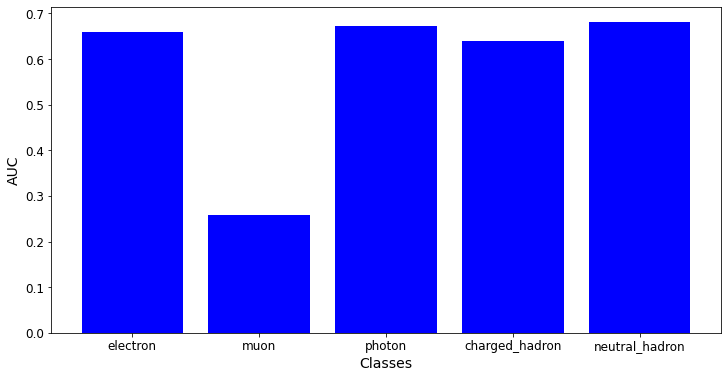

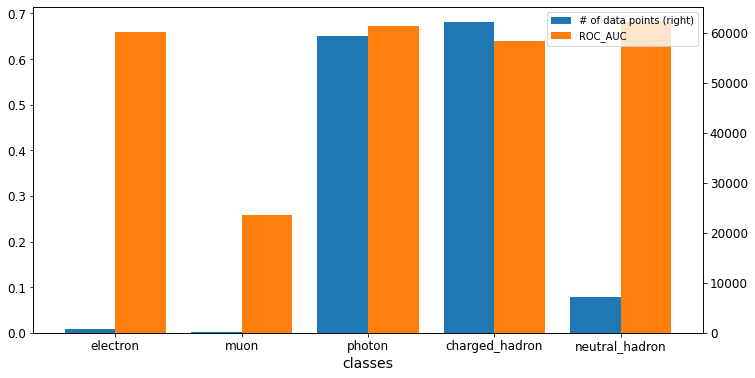

In [30]:
plot_class_balance_and_AUC(class_dict, roc_auc_ovr, PDG_CLASSES, odir)